энкодер- декодер на основе сверточной сети. надо сделать не fit модели а train step.

In [1]:
# from keras.datasets import mnist
import numpy as np
# from jaw_gen import *
import tensorflow
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model

import tensorflow.keras.backend as K
from tensorflow.keras.layers import Lambda
import cv2

from tqdm import tqdm

In [2]:
# import keras
print (f"keras ver.{tensorflow.keras.__version__}")
# print (f"keras ver.{1}")

keras ver.2.6.0


In [3]:
# класс который генерит картинки размерностью с искривлениями зубов или без.

red = (0, 0, 255)
white = (255, 255, 255)

# print(f" cv2 ver. {cv2.__version__}, np ver. {np.__version__}")
np.random.seed() # устанавливает режим случайных чисел без повторений от запуска к запуску

class Landmark_gen():
    ''' creates pictures with incistor edges landmarks '''

    def __init__(self, number=100, dim=(200, 200), x_axes=(-10, 10), y_axes=(-200, 10)):
        self.number = number
        self.dim = dim
        self.x_axes = x_axes
        self.y_axes = y_axes

    def image_gen(  self, 
                    name='_', 
                    scale1=1, 
                    factor=2.6, 
                    shift_x=0, 
                    shift_y=0, 
                    spoiled = False, # вводит хаотичный наклон и смещение зубов имитируя T1
                    show=False):
        # встроить сюда еще смещение 
        # все делаем под разрешение 200x200 
        self.back = np.zeros((200, 200))            # картинка с ровными зубами
        self.back_spoiled = np.zeros((200,200))     # картинка с корявыми зубами
        self.factor = factor
        center = (100, 100)

        # оси координат по центру
        if 1:
            cv2.line(self.back, (0, center[1]), (200, center[1]), 0.4, 1)
            cv2.line(self.back, (center[0], 0), (center[0], 200), 0.4, 1)
            cv2.line(self.back_spoiled, (0, center[1]), (200, center[1]), 0.4, 1)
            cv2.line(self.back_spoiled, (center[0], 0), (center[0], 200), 0.4, 1)

        # строим дугу. так чтобы на основе ее точек можно было зубья подровнять
        for i in range(-8, 8):
            # строим точки графика
            # первая точка зуба
            point_ = [int(i*scale1)+center[0], int(self.duga(i)) + center[1]]
            # вторая
            point2_ = [int((i+1-0.2)*scale1 +
                          center[0]), int(self.duga(i+1-0.2)) + center[1]]
            
            # строим линии по дуге - ровные зубы
            cv2.line(self.back, point_, point2_, 1, 2)

            # шатаем зубы если задано шатать и выдаем на картинку back_spoiled
            if spoiled: 
                
                if i in [-8, -7, -6, 5, 6, 7 ]: # портим моляры 
                    point_[0]+= int((np.random.sample()-1)*i)

                if i in [-5, -4, -3, -2, 1, 2, 3, 4]: # премоляры и резцы
                    point_[1]+= int((np.random.sample()-1)*i*2)

                if i in [-1, 0]: # передние резцы
                    point_[1]+= int((np.random.sample()-1)*4)

            # для второй картинки сторим покореженные зубы. или те-же если корежить не надо
            cv2.line(self.back_spoiled, point_, point2_, 1, 2)
            
            # cv2.circle(self.back, point_, 1, 0.2, 1)
        # print (f"self.back shape {self.back.shape}")

        if show: # shows picture. beware using in batсh processing
            self.back = cv2.resize(self.back, self.dim)  # увеличиваем только для показа
            self.back_spoiled = cv2.resize(self.back_spoiled, self.dim)  # увеличиваем только для показа
            img_for_show = np.hstack((self.back, self.back_spoiled))
            cv2.imshow(name, img_for_show)
            k = cv2.waitKey()

        return self.back, self.back_spoiled  

    def duga(self, x):
        ''' returns arc function'''
        return abs(x)**self.factor - 200 * 0.35


In [4]:
# готовим входные данные
inst_ = Landmark_gen()
data_len = 10000
dataset = []
dataset_spoiled = []

for i in range(data_len):
    scale =  9 + np.random.sample()*3     # это для размера 200, диапазон от 14 до 19 для размера 400
    factor = 2.2 + np.random.sample()/4   # это для размера 200, диапазон 2.5 - 2.7 для размера 400 
    # name = f"scale {scale:.4}  factor {factor:.3}"
    img_, img_spoiled_ = inst_.image_gen(scale1=scale, factor=factor, spoiled=True)
    dataset.append(img_)
    dataset_spoiled.append(img_spoiled_)


set_divider_ = round(data_len*0.8)
# print (f"set_divider_ {set_divider_}")

x_train = dataset[:set_divider_]
x_test = dataset[set_divider_:]
# print (f"length {len(x_train)} - {len(x_test)}")

x_train_spoiled = dataset_spoiled[:set_divider_]
x_test_spoiled = dataset_spoiled[set_divider_:]

# конвертнем данные
x_train = np.array(x_train, dtype="float32")    # x_train = x_train.astype('float32') / 255. 
x_test  = np.array(x_test, dtype="float32")      # x_test  = x_test .astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 200, 200, 1))
x_test  = np.reshape(x_test,  (len(x_test),  200, 200, 1))

x_train_spoiled = np.array(x_train_spoiled, dtype="float32")   
x_test_spoiled  = np.array(x_test_spoiled, dtype="float32")    
x_train_spoiled = np.reshape(x_train_spoiled, (len(x_train_spoiled), 200, 200, 1))
x_test_spoiled  = np.reshape(x_test_spoiled,  (len(x_test_spoiled),  200, 200, 1))


In [5]:
def create_deep_conv_ae():
    input_img = Input(shape=(200, 200, 1))

    x = Conv2D(128, (7, 7), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    encoded = Conv2D(1, (3, 3), activation='relu', padding='same')(x) # в оригинале тут оставался один фильтр. 

    # На этом моменте представление  (50, 50, 8) т.е. 20000-размерное нихера сибе. посмотрим как будет учиться Уже нет. уже (50, 50, 1)

    input_encoded = Input(shape=(50, 50, 1))
    x = Conv2D(32, (7, 7), activation='relu', padding='same')(input_encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(128, (2, 2), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (7, 7), activation='sigmoid', padding='same')(x)

    # Модели
    encoder = Model(input_img, encoded, name="encoder")
    decoder = Model(input_encoded, decoded, name="decoder")
    autoencoder = Model(input_img, decoder(encoder(input_img)), name="autoencoder")
    return encoder, decoder, autoencoder

c_encoder, c_decoder, c_autoencoder = create_deep_conv_ae()
c_autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# c_autoencoder.summary()

In [6]:
batch_size = 16

def create_denoising_model(autoencoder):
    def add_noise(x):
        noise_factor = 0.5
        # x = x + K.random_normal(x.get_shape(), 0.5, noise_factor) # не шумим. тсс...
        x = K.clip(x, 0., 1.)
        return x

    input_img  = Input(batch_shape=(batch_size, 200, 200, 1))
    input_img_spoiled  = Input(batch_shape=(batch_size, 200, 200, 1)) # вход для кореженных зубьев

    # noised_img = Lambda(add_noise)(input_img) # больше не нужен шум

    # noiser = Model(input_img, noised_img, name="noiser") # и моделька шумелка не нужна
    # denoiser_model = Model(input_img, autoencoder(noiser(input_img)), name="denoiser") # это старая оригинальная модель
    denoiser_model = Model([input_img, input_img_spoiled], autoencoder(input_img_spoiled), name="denoiser")
    # return noiser, denoiser_model
    return denoiser_model


# noiser, denoiser_model = create_denoising_model(c_autoencoder)
denoiser_model = create_denoising_model(c_autoencoder)
denoiser_model.compile(optimizer='adam', loss='binary_crossentropy')

In [7]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

def plot_digits(*args):
    args = [x.squeeze() for x in args]
    n = min([x.shape[0] for x in args])
    
    plt.figure(figsize=(2*n, 2*len(args)))
    for j in range(n):
            for i in range(len(args)):
                ax = plt.subplot(len(args), n, i*n + j + 1)
                plt.imshow(args[i][j])
                plt.gray()
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)

    plt.show()

Epoch 1


100%|██████████| 500/500 [02:29<00:00,  3.34it/s]


Epoch 2


100%|██████████| 500/500 [02:14<00:00,  3.72it/s]


Epoch 3


100%|██████████| 500/500 [02:14<00:00,  3.71it/s]


Epoch 4


100%|██████████| 500/500 [02:19<00:00,  3.59it/s]


Epoch 5


100%|██████████| 500/500 [02:19<00:00,  3.58it/s]


Epoch 6


100%|██████████| 500/500 [02:07<00:00,  3.91it/s]


Epoch 7


100%|██████████| 500/500 [02:05<00:00,  3.97it/s]


Epoch 8


100%|██████████| 500/500 [02:05<00:00,  3.97it/s]


Epoch 9


100%|██████████| 500/500 [02:05<00:00,  3.97it/s]


Epoch 10


100%|██████████| 500/500 [02:12<00:00,  3.78it/s]


Epoch 11


100%|██████████| 500/500 [02:15<00:00,  3.70it/s]


Epoch 12


100%|██████████| 500/500 [02:24<00:00,  3.46it/s]


Epoch 13


100%|██████████| 500/500 [02:20<00:00,  3.56it/s]


Epoch 14


100%|██████████| 500/500 [02:33<00:00,  3.25it/s]


Epoch 15


100%|██████████| 500/500 [02:12<00:00,  3.77it/s]


Epoch 16


100%|██████████| 500/500 [02:10<00:00,  3.84it/s]


Epoch 17


100%|██████████| 500/500 [02:11<00:00,  3.80it/s]


Epoch 18


100%|██████████| 500/500 [02:05<00:00,  3.98it/s]


Epoch 19


100%|██████████| 500/500 [02:05<00:00,  4.00it/s]


Epoch 20


100%|██████████| 500/500 [02:05<00:00,  3.97it/s]


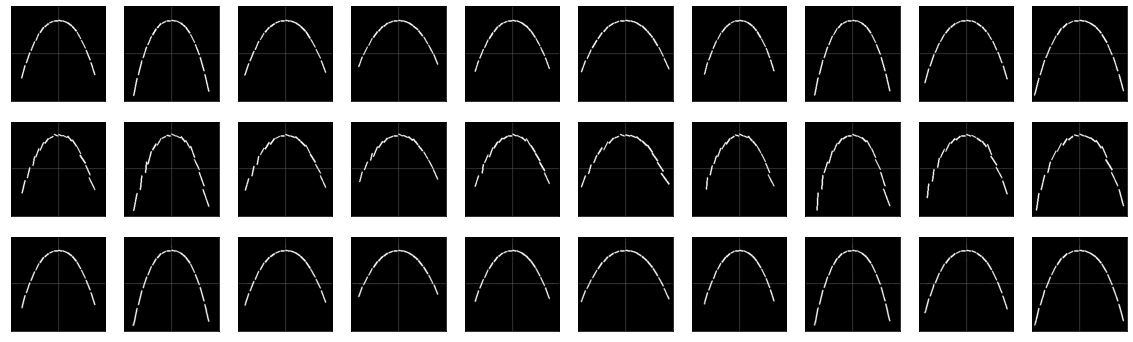

Epoch 21


100%|██████████| 500/500 [02:06<00:00,  3.97it/s]


Epoch 22


100%|██████████| 500/500 [02:06<00:00,  3.97it/s]


Epoch 23


100%|██████████| 500/500 [02:06<00:00,  3.95it/s]


Epoch 24


100%|██████████| 500/500 [02:06<00:00,  3.94it/s]


Epoch 25


100%|██████████| 500/500 [02:05<00:00,  3.98it/s]


Epoch 26


100%|██████████| 500/500 [02:05<00:00,  3.97it/s]


Epoch 27


100%|██████████| 500/500 [02:09<00:00,  3.85it/s]


Epoch 28


100%|██████████| 500/500 [02:06<00:00,  3.95it/s]


Epoch 29


100%|██████████| 500/500 [02:05<00:00,  3.98it/s]


Epoch 30


100%|██████████| 500/500 [02:07<00:00,  3.92it/s]


Epoch 31


100%|██████████| 500/500 [02:06<00:00,  3.96it/s]


Epoch 32


100%|██████████| 500/500 [02:12<00:00,  3.77it/s]


Epoch 33


100%|██████████| 500/500 [02:11<00:00,  3.81it/s]


Epoch 34


100%|██████████| 500/500 [02:13<00:00,  3.74it/s]


Epoch 35


100%|██████████| 500/500 [02:10<00:00,  3.84it/s]


Epoch 36


100%|██████████| 500/500 [02:13<00:00,  3.75it/s]


Epoch 37


100%|██████████| 500/500 [02:09<00:00,  3.87it/s]


Epoch 38


100%|██████████| 500/500 [02:07<00:00,  3.91it/s]


Epoch 39


100%|██████████| 500/500 [02:06<00:00,  3.96it/s]


Epoch 40


100%|██████████| 500/500 [02:05<00:00,  3.97it/s]


In [8]:
# вместо фита будем делать  model.train_on_batch читобы смотреть как учится и куда движемся
def train_on_batch(x, x_spoil, batch_size=batch_size, epochs=100):
    # подровняем массив обучащих так чтоб np.reshape не ругался на несовпадение размерности
    x = x[:len(x_train)//batch_size*batch_size]
    x = np.reshape(x, (-1, batch_size, 200, 200, 1)) # x_test  = np.reshape(x_test,  (len(x_test),  200, 200, 1))
    
    # и массив кореженных тоже
    x_spoil = x_spoil[:len(x_train_spoiled)//batch_size*batch_size]
    x_spoil = np.reshape(x_spoil, (-1, batch_size, 200, 200, 1)) 
    
    for epoch in range(1, epochs+1):
        print(f"Epoch {epoch}")
        for i, _ in enumerate(tqdm(x)):
            batch_x = x[i]
            batch_x_spoiled = x_spoil[i]
            denoiser_model.train_on_batch([batch_x, batch_x_spoiled], batch_x)

        # эпоха отучилась, построим что вышло.
        n = 10
        imgs = batch_x
        # noised_imgs = noiser.predict(imgs, batch_size=batch_size)
        noised_imgs = batch_x_spoiled
        encoded_imgs = c_encoder.predict(noised_imgs[:n],  batch_size=n)
        decoded_imgs = c_decoder.predict(encoded_imgs[:n], batch_size=n)

        # рисуем картинки и сохраняем модели
        if ((epoch % 20 ==0) or (epoch == epochs-1)):
            plot_digits(imgs[:n], noised_imgs, decoded_imgs)
            denoiser_model.save(f'models/denoiser_1_flt_{epoch}ep.h5')
            c_decoder.save(f'models/c_decoder_1_flt_{epoch}ep.h5')
            c_encoder.save(f'models/c_encoder_1_flt_{epoch}ep.h5')
        
# train_on_batch(x_train, batch_size=batch_size, epochs=100)
train_on_batch(x_train, x_train_spoiled, batch_size=batch_size, epochs=100)

In [ ]:
denoiser_model.save('models/denoiser_1_flt_100ep.h5')
c_decoder.save('models/c_decoder_1_flt_100ep.h5')
c_encoder.save('models/c_encoder_1_flt_100ep.h5')

n = 10

imgs = x_test[:batch_size]
noised_imgs = noiser.predict(imgs, batch_size=batch_size)
encoded_imgs = с_encoder.predict(noised_imgs[:n],  batch_size=n)
decoded_imgs = с_decoder.predict(encoded_imgs[:n], batch_size=n)

plot_digits(imgs[:n], noised_imgs, decoded_imgs)
# plot_digits(imgs[:n], decoded_imgs)

encoded_imgs[:20]